github link: https://github.com/ShlomiFridman/PhoenixProject2025

In [2]:
!pip install requests beautifulsoup4
!pip install requests beautifulsoup4 nltk
!pip install firebase

In [3]:
import requests
import time
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from urllib.robotparser import RobotFileParser
from nltk.stem import PorterStemmer
import re
from firebase import firebase

Utils functions

In [4]:
def index_words(soup):
    index_res = {}
    words = re.findall(r'\w+', soup.get_text())

    for word in words:
        word = word.lower()

        if word in index_res:
            index_res[word] += 1
        else:
            index_res[word] = 1

    return index_res

def remove_stop_words(p_index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at', 'to'}

    for stop_word in stop_words:
        if stop_word in p_index:
            del p_index[stop_word]

    return p_index

def apply_stemming(p_index):
    stemmer = PorterStemmer()
    stemmed_index = {}

    for word, count in p_index.items():
        stemmed_word = stemmer.stem(word)

        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count

    return stemmed_index


Firebase service

In [5]:
class FirebaseService:

  def __init__(self, db_url = 'https://phoenixhw2-default-rtdb.europe-west1.firebasedatabase.app/'):
    self.FBconn = firebase.FirebaseApplication(db_url,None)

  def get_index_from_DB(self):
    return self.FBconn.get('/Index/', None)

  def update_index_in_db(self, index_p):
    for k,v in index_p.items():
      self.FBconn.put("/Index/", k, v)
      print(f"update made for index={k} ({v['term']})")
    print("Updated given index in DB")

index service for maintain

In [40]:
class IndexService:

  def __init__(self, index):
    self.rev_index = {}
    self.urls_index = {}
    stemmer = PorterStemmer()
    for w in index:
      self.rev_index[stemmer.stem(w)] = {"term":w, "DocIDs": [], "DocIDs_cntrs": []}

  def process_soup(self, url, soup):
    if not soup:
      print("empty soup")
      return
    u_index = index_words(soup)
    u_index = remove_stop_words(u_index)
    u_index = apply_stemming(u_index)
    self.urls_index[url] = u_index

    for ind, ind_val in self.rev_index.items():
      if ind not in u_index:
        continue
      elif url in ind_val['DocIDs']:
        continue
      ind_val['DocIDs'].append(url)
      ind_val['DocIDs_cntrs'].append(u_index[ind])

    return u_index

  def get_reverse_index(self):
    return self.rev_index

  def get_url_index(self, url):
    return self.urls_index.get(url,{})

  def set_index(self, newRevIndex):
    self.rev_index = newRevIndex
    self.urls_index = {}

    for ind, vals in self.rev_index.items():
      urls = vals['DocIDs']
      cntrs = vals['DocIDs_cntrs']
      for j in range(len(vals['DocIDs'])):
        if urls[j] not in self.urls_index:
          self.urls_index[urls[j]] = {}
        self.urls_index[urls[j]][ind] = cntrs[j]
    print("index updated")

  def index_toString(self):
    str = ''
    for ind,vals in self.rev_index.items():
      str += f"Index {ind}"
      str += f"\tTerm={vals['term']}"
      str += "\tDocIDs="
      for j in range(len(vals['DocIDs'])):
        str += f"\t\tURL No.{j}: {vals['DocIDs'][j]} - {vals['DocIDs_cntrs'][j]} times"
    return str


Crawling service

In [7]:
class CrawlerService:

  def __init__(self, indexService):
    self.indexService = indexService
    self.crawled_urls = set()
    self.crawled_count = 0
    self.robot = None

    # Function to crawl a website and fetch n pages
  def crawl_website(self, base_url, max_pages):
      rp = self.__check_robot(base_url)  # Check the robots.txt file
      urls_to_crawl = [base_url]  # Initialize the queue with the base URL
      current_crawled_urls = set()
      ignore_urls = ["form", "mp3", "mp4", "downloads"]

      while urls_to_crawl and len(current_crawled_urls) < max_pages:
          current_url = urls_to_crawl.pop(0)

          if current_url in self.crawled_urls:
              continue  # Skip already crawled URLs

          print(f"Crawling {self.crawled_count+1}: {current_url}")
          page_content = self.__fetch_page_crawler(current_url, rp)

          if page_content:
              self.crawled_urls.add(current_url)
              current_crawled_urls.add(current_url)
              self.crawled_count += 1

              # Extract and queue new links to crawl
              new_links = self.__extract_links(page_content, base_url)
              for link in new_links:
                  cond1 = any(bad_url in link for bad_url in ignore_urls)
                  cond2 = any(u for u in self.crawled_urls if (f"{u}#" in link))
                  cond = cond1 or cond2
                  if link not in self.crawled_urls and link not in urls_to_crawl and not cond:
                      urls_to_crawl.append(link)

              soup = BeautifulSoup(page_content, 'html.parser')
              self.indexService.process_soup(current_url, soup)
              # Delay between requests to avoid overwhelming the server
              time.sleep(2)  # Sleep for 2 seconds between requests (politeness)

      print(f"\nCrawled {len(current_crawled_urls)} pages.")
      return current_crawled_urls

  def get_crawled_urls(self):
    return self.crawled_urls

  # Function to fetch and parse the robots.txt file to check permissions
  def __check_robot(self, url):
      robot_url = urljoin(url, '/robots.txt')
      rp = RobotFileParser()
      rp.set_url(robot_url)
      # Fetch and parse robots.txt file
      rp.read()
      if rp:
        self.robot = rp
      return rp if rp else self.robot

  # Function to fetch and parse a page
  def __fetch_page_crawler(self, url, rp):
      # Check if the URL is allowed to be crawled according to robots.txt
      if not rp.can_fetch('*', url):  # '*' means all user agents
          print(f"Blocked by robots.txt: {url}")
          return None

      try:
          response = requests.get(url, timeout=5)
          response.raise_for_status()  # Will raise an exception for 4xx or 5xx responses
          return response.text
      except requests.exceptions.RequestException as e:
          print(f"Error fetching {url}: {e}")
          return None

  # Function to extract internal links from a page
  def __extract_links(self, page_content, base_url):
      soup = BeautifulSoup(page_content, 'html.parser')
      links = set()

      # Find all anchor tags and extract the href attribute
      # TODO need to add all links that are in tags with property cta-type="local
      for anchor in soup.find_all('a', href=True):
          href = anchor['href']

          # Resolve relative URLs to absolute URLs
          full_url = urljoin(base_url, href)

          # Only add links that are within the same domain (ibm.com)
          if urlparse(full_url).netloc == urlparse(base_url).netloc:
              links.add(full_url)
      for tag in soup.find_all(attrs={'cta-type': 'local'}, href=True):
        href = tag['href']
        # Resolve relative URLs to absolute URLs
        full_url = urljoin(base_url, href)

        # Only add links that are within the same domain
        if urlparse(full_url).netloc == urlparse(base_url).netloc:
            links.add(full_url)

      return links

The index we defined

In [42]:
init_index = [
    'SAAS',
    'PAAS',
    'IAAS',
    'Private',
    'Public',
    'Hybrid',
    'Service',
    'Platform',
    'Infrastructure',
    'Study',
    'Case',
    'Chatbot',
    'Engine',
    'Cloud',
    'Monitor',
    'Data',
    'Mainframe',
    'Performance',
    'Security',
    'SLA',
    'KPI',
    'SOA',
    'Information',
    'Kafka',
    'SQL',
    'Technology',
    'Database',
    'Docker',
    'Kubernetes',
    'RabbitMQ',
    'IBM',
    'Google',
    'Amazon',
    'AI',
]

In [43]:
indexService = IndexService(init_index)

In [44]:
crawlerService = CrawlerService(indexService)

In [45]:
firebaseService = FirebaseService()

In [ ]:
# indexService.set_index(firebaseService.get_index_from_DB())
# print("Index from firebase:")
# indexService.print_index()

Processing the index and saving it in DB

In [46]:
firebaseService.update_index_in_db(indexService.get_reverse_index())

update made for index=saa (SAAS)
update made for index=paa (PAAS)
update made for index=iaa (IAAS)
update made for index=privat (Private)
update made for index=public (Public)
update made for index=hybrid (Hybrid)
update made for index=servic (Service)
update made for index=platform (Platform)
update made for index=infrastructur (Infrastructure)
update made for index=studi (Study)
update made for index=case (Case)
update made for index=chatbot (Chatbot)
update made for index=engin (Engine)
update made for index=cloud (Cloud)
update made for index=monitor (Monitor)
update made for index=data (Data)
update made for index=mainfram (Mainframe)
update made for index=perform (Performance)
update made for index=secur (Security)
update made for index=sla (SLA)
update made for index=kpi (KPI)
update made for index=soa (SOA)
update made for index=inform (Information)
update made for index=kafka (Kafka)
update made for index=sql (SQL)
update made for index=technolog (Technology)
update made for i

In [47]:

# To limit the number of pages to crawl
MAX_PAGES = 100
crawlerService.crawl_website('https://www.ibm.com/us-en', MAX_PAGES)
crawlerService.crawl_website('https://www.ibm.com/topics', MAX_PAGES)

Crawling 1: https://www.ibm.com/us-en
Crawling 2: https://www.ibm.com/impact/ai-ethics?lnk=bus
Crawling 3: https://www.ibm.com/servers?lnk=ProdC
Crawling 4: https://www.ibm.com/thought-leadership/institute-business-value/report/ceo-generative-ai?lnk=bus
Crawling 5: https://www.ibm.com/think/reports/ai-in-action?lnk=bus
Crawling 6: https://www.ibm.com/think/insights/ai-ethics-and-governance-in-2025?lnk=hpUSls2
Crawling 7: https://www.ibm.com/products/watsonx-code-assistant?lnk=dev
Crawling 8: https://www.ibm.com/about?lnk=inside
Crawling 9: https://www.ibm.com/impact?lnk=inside
Crawling 10: https://www.ibm.com/automation?lnk=ProdC
Crawling 11: https://www.ibm.com/history?lnk=inside
Crawling 12: https://www.ibm.com/analytics?lnk=ProdC
Crawling 13: https://www.ibm.com/artificial-intelligence?lnk=ProdC
Crawling 14: https://www.ibm.com/new/announcements/scale-ai-with-ibm-s-forward-thinking-data-strategy?lnk=hpUSrc3
Crawling 15: https://www.ibm.com/impact/be-equal?lnk=inside
Crawling 16: htt

{'https://www.ibm.com/blog/x-force-cloud-threat-landscape/',
 'https://www.ibm.com/data-security',
 'https://www.ibm.com/security',
 'https://www.ibm.com/services/security',
 'https://www.ibm.com/services/threat-detection-response',
 'https://www.ibm.com/think/insights/ai-risk-management',
 'https://www.ibm.com/think/podcasts',
 'https://www.ibm.com/think/topics/ai-security',
 'https://www.ibm.com/think/topics/lateral-movement',
 'https://www.ibm.com/think/videos',
 'https://www.ibm.com/thought-leadership/institute-business-value/report/securing-generative-ai',
 'https://www.ibm.com/topics',
 'https://www.ibm.com/topics/api',
 'https://www.ibm.com/topics/artificial-intelligence',
 'https://www.ibm.com/topics/attack-surface-management',
 'https://www.ibm.com/topics/automation',
 'https://www.ibm.com/topics/block-storage',
 'https://www.ibm.com/topics/business-email-compromise',
 'https://www.ibm.com/topics/business-intelligence',
 'https://www.ibm.com/topics/byod',
 'https://www.ibm.com

In [48]:
firebaseService.update_index_in_db(indexService.get_reverse_index())

update made for index=saa (SAAS)
update made for index=paa (PAAS)
update made for index=iaa (IAAS)
update made for index=privat (Private)
update made for index=public (Public)
update made for index=hybrid (Hybrid)
update made for index=servic (Service)
update made for index=platform (Platform)
update made for index=infrastructur (Infrastructure)
update made for index=studi (Study)
update made for index=case (Case)
update made for index=chatbot (Chatbot)
update made for index=engin (Engine)
update made for index=cloud (Cloud)
update made for index=monitor (Monitor)
update made for index=data (Data)
update made for index=mainfram (Mainframe)
update made for index=perform (Performance)
update made for index=secur (Security)
update made for index=sla (SLA)
update made for index=kpi (KPI)
update made for index=soa (SOA)
update made for index=inform (Information)
update made for index=kafka (Kafka)
update made for index=sql (SQL)
update made for index=technolog (Technology)
update made for i

<ipython-input-49-4852d522e83c>:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(x="Index", y="Appearances",


<Figure size 640x480 with 0 Axes>

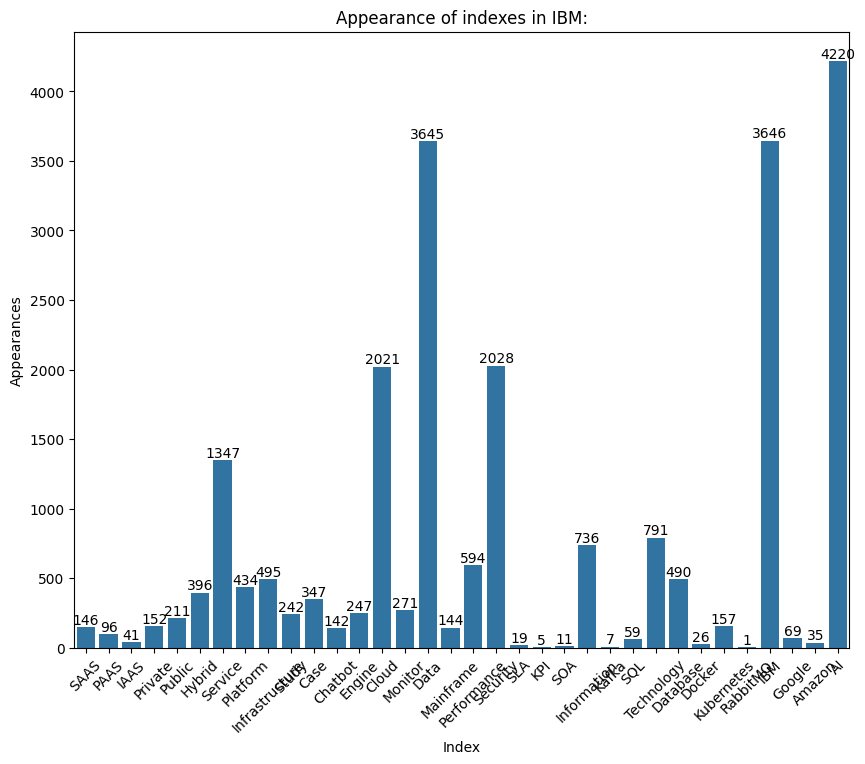

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def displayCntrGraph(index):
  ind_names = [ind["term"] for ind in index.values()]
  ind_cntrs = [sum(ind["DocIDs_cntrs"]) for ind in index.values()]
  ind_data = pd.DataFrame({
      "Index":ind_names,
      "Appearances":ind_cntrs
  })

  plt.clf()  # Clear the current figure
  plt.figure(figsize=(10, 8))  # Increased figure size to accommodate labels
  plt.title("Appearance of indexes in IBM:")

  ax = sns.barplot(x="Index", y="Appearances",
                  errwidth=0, data=ind_data)
  for i in ax.containers:
    ax.bar_label(i,)
  plt.xticks(rotation=45)
  plt.show()  # Add this to display the plot
  plt.close()  # Close the figure to free memory

displayCntrGraph(indexService.get_reverse_index())

In [ ]:
searchHistory = []

TODO search engine by text field, you can use the code from exercise 6, save the search history

TODO 3 tabs: search results, graph that shows the rank of each page, graph for the website cover of the query keywords

TODO add the group logo from drive

TODO enable shering, make the link public